In [1]:
#Going to try to make a streamlined version of Process_LCDRI_1Hz that can just be called from an external folder
#Maybe going to put this into /src eventually but for now do a script.

"""
Inputs: /dec directory

Outputs: Timeseries' of: time, Hs, spectra, locations


"""



from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2
###########################


nblock = 120
fs = 1
overlap = 60

### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
#fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
#save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"



In [2]:
def process_waves(folder_name):

    #input the equivalent of dec name in case the filenaming system is not consitent across 
    up_count = 0
    down_count = 0
    up = True

    float_id_counter = 0
    ignore_count = 0
    too_deep_counter = 0
    min_bin = []
    first_bot = []
    
    #Loop through each profile for that float
    files = os.listdir(folder_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    gps_files = [file for file in files if "gps.mat" in file and not file.startswith('.')]
    
    #print(efr_files)
    spec_store = np.zeros((len(efr_files), 2 , (nblock//2)-1))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    prof_speed_store = np.zeros(len(efr_files))
    rotf_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 3))
    loc_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    counter=0
    lats1 = []
    lats2 = []
    lons1 = []
    lons2 = []
    times1=[]
    times2=[]
    #Load each profiling file, and then calculate the 1D spectrum
    GPS_storer = np.array([])

#     for file in gps_files:
#         fname = folder_name+file
        
#         GPS = loadmat(gpsfname)
         
#         if len(GPS_storer)==0:
#             GPS_storer = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T
            
#         else:
#             temp = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T
#             GPS_storer = np.append(GPS_storer, temp, axis=0)

#     GPS_storer = GPS_storer[~np.isnan(GPS_storer[:, 1]), :]

    #gpsfile = folder_name.split("/ohm")
    for file in efr_files:
        fname = folder_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
            comp_time = mlt_efr[-1]


        else:
            up = False
            comp_time = mlt_efr[0]


            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = folder_name+new_file
       
        GPS = loadmat(gpsfname)
         
        if len(GPS_storer)==0:
            GPS_storer = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T
            
        else:
            temp = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T
            GPS_storer = np.append(GPS_storer, temp, axis=0)
           
        #get rid of all the NaNs
        #print(GPS_storer)
        GPS_storer = GPS_storer[~np.isnan(GPS_storer[:, 1]), :]
        #if this doesn't work, try again moving up 1 more?
        if len(GPS_storer)==0:
            if up:
                new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+2)+'-gps.mat'
            else:
                new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+3)+'-gps.mat'


            gpsfname = folder_name+new_file
       
            GPS = loadmat(gpsfname)

            if len(GPS_storer)==0:
                GPS_storer = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T

            else:
                temp = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T
                GPS_storer = np.append(GPS_storer, temp, axis=0)
                GPS_storer = GPS_storer[~np.isnan(GPS_storer[:, 1]), :]
            
        closest_gps_ind = np.where(np.abs(comp_time-GPS_storer[:, 0])==np.min(np.abs(comp_time-GPS_storer[:, 0])))
        
        
        closest_gps_ind = closest_gps_ind[0][0]


        lat = GPS_storer[closest_gps_ind, 1]
        lon = GPS_storer[closest_gps_ind, 2]
        gps_time = GPS_storer[closest_gps_ind, 0]
                                   
        lats1 = np.append(lats1, lat)
        lons1 = np.append(lons1, lon)
        times1 = np.append(times1, gps_time)
        
#         LAT = GPS["LAT"]
#         LON = GPS["LON"]
#         TIME = GPS['UXT_GPS']
#         if len(LAT[~np.isnan(LAT)])==0:
#             times1 = np.append(times1, TIME[0][0])
#             times2 = np.append(times2, TIME[0][-1])
                                            
#         else:
#             lats1 = np.append(lats1, LAT[~np.isnan(LAT)][0])
#             lats2 = np.append(lats2, LAT[~np.isnan(LAT)][-1])
#             lons1 = np.append(lons1, LON[~np.isnan(LAT)][0])
#             lons2 = np.append(lons2, LON[~np.isnan(LAT)][-1])
#             times1 = np.append(times1, TIME[~np.isnan(LAT)][0])
#             times2 = np.append(times2, TIME[~np.isnan(LAT)][-1])
        

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)
        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Uncomment this to print out the filenames where EM starts before CTD
        #if len(moving_inds)<len(Pef):
            #print(len(Pef)-len(moving_inds), fname)
            #continue
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef = Pef[moving_inds]
        
        #[HX, HY] = correct_magnetometer(HX, HY)
        
        #a,b = signal.butter(1, 0.04, 'hp', fs=1, analog=False)
        #E1_filtered = signal.filtfilt(a, b, E1)
        #E2_filtered = signal.filtfilt(a, b, E2)
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        ## Do spike detection
        #If either channel has spikes, ignore the profile.
        spikes=contains_spikes(E1, E2)
        if spikes:
            print("SPIKES IN, ", fname)
            continue
        
        
        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        
        
    
        ##Get the mean residual level below 90m for the purpose of estimating error
        deep_inds = np.where(Pef>=90)
        error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
        #resid_store = np.append(resid_store, error)
        
        
        #Now take the spectra

        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        #If there's only one block worth of data, ignore the profile
        
      
        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
        
        #if up:
        #    print(np.nanmean(prof_speed), "up")
        #else:
        #    print(np.nanmean(prof_speed), "down")
            
        if u_x.shape[0]==1:
            continue
        prof_speed_new = np.zeros(len(prof_speed))
        for block_ind in range(z_x.shape[0]):
            prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
            z_inds = prof_speed_try<0.001
            prof_speed_try[z_inds]=np.nan
            prof_speed_removed_zeros = np.nanmean(prof_speed_try)
            prof_speed_new[block_ind]=prof_speed_removed_zeros

        prof_speed = prof_speed_new
        
            
        #Get teh rotation frequency
        time_s = np.abs(mlt_efr - mlt_efr[0])
        rad_per_s = np.gradient(avg_angs, time_s) #radians per second. rotation period is 2pi/rad_per_s
        rotf = rad_per_s/2/np.pi
        
        [rotf_reshaped, _] = reshape_u(rotf, Pef, nblock, overlap, fs)
        
        window_rotf = np.nanmean(rotf_reshaped, axis=1)
        
        
        zero_inds = np.where(prof_speed==0)[0]
        #if len(zero_inds)>0:
            #print(z_x[0, :])
            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)

        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
            print("HELLO TOO DEEP!")
        else:  
            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

            Eh = Exx+Eyy
            
           # if np.isnan(np.nanmean(np.nanmean(Eh, axis=0))):
                #print("All NaNs!!")
                #if nancounter==0:
                    #plt.loglog(fwindow, np.transpose(VVwindow))
                    #plt.plot(np.transpose(u_y))
                    #plt.loglog(fwindow[1:], np.transpose(Eh))
                #    print(make_vel_spectrum(u_y, fs))
                    
               # temp1 = np.expand_dims(np.array(E_x), axis=0)
               # temp2 = np.expand_dims(np.array(E_y), axis=0)
                #temp3 = np.append(temp1, temp2, axis=0)
                #nanstorer.append(temp3)
                #if nancounter<10:
                #    plt.figure()
                #    plt.plot(E_x)
                #    plt.plot(E_y)
                #nancounter+=1
                
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            G1 = Eh_Eric2/Eh_Eric1
            G2 = Eh_Eric3/Eh_Eric2
            G3 = Eh_Eric4/Eh_Eric3
            
            if prof_num%2==0 & up_count==0:
                
                k_array = np.square(2*np.pi*fwindow[1:])/9.8
                k_mat = np.tile(k_array, (Eh.shape[0], 1))
                z_mat = z_x
                z_mat = np.tile(np.expand_dims(np.nanmedian(z_mat, axis=1), axis=1), (1, len(k_mat[0, :])))
                prof_speed_u = np.tile(np.expand_dims(prof_speed_new, axis=1), (1, Eh.shape[1]))
                kWT2_up = 1*k_mat*prof_speed_u*(nblock/fs)
                up_count=1
                
                #print(np.nanmean(G1), np.nanmean(G2), np.nanmean(G3), "up")
            else:
                if down_count==0:
                    k_array = np.square(2*np.pi*fwindow[1:])/9.8
                    k_mat = np.tile(k_array, (Eh.shape[0], 1))
                    z_mat = z_x
                    z_mat = np.tile(np.expand_dims(np.nanmedian(z_mat, axis=1), axis=1), (1, len(k_mat[0, :])))
                    prof_speed_d = np.tile(np.expand_dims(prof_speed_new, axis=1), (1, Eh.shape[1]))
                    kWT2_down = 1*k_mat*prof_speed_d*(nblock/fs)
                    down_count=1
                #print(np.nanmean(G1), np.nanmean(G2), np.nanmean(G3), "down")
                
            if np.isnan(Eh_Eric4).all():
                print("HELLO SEEM TO HAVE NANs")
                continue
                #Then what happens is the float never moved?
                #What if we just try applying the depth correction
                k_array = np.square(2*np.pi*fwindow[1:])/9.8
                k_mat = np.tile(k_array, (Eh.shape[0], 1))

                #This is def not the easiest way to do this
                #z_mat = np.tile(em_z, (Eh.shape[0], 1))
                z_mat = z_x
                z_mat = np.tile(np.expand_dims(np.nanmedian(z_mat, axis=1), axis=1), (1, len(k_mat[0, :])))
                #print(z_mat)


                depth_fact = np.exp(2*k_mat*z_mat)
                depth_fact[np.exp(k_mat*z_mat)>Cmax]=np.nan
                #depth_fact[depth_fact>Cmax]=np.nan
                Eh_Eric4 = Eh*depth_fact
            
            u_noise = 0 #This is just for testing...
            [lbound, ubound, nu] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            #print(lbound)
            #print(ubound)
            #Try propogating errors through and see if this has a different result
            #Eh_lbound = Eh*lbound
            #Eh_ubound = Eh*ubound
            
            if ubound>5:
                print(prof_num)
                plt.plot(E_x)
                get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs, debug_flag=True)
                print(u_x.shape)
            #[_, _, _, Eh_Eric4_lbound] = depth_correct_Eric(Eh_lbound, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            #[_, _, _, Eh_Eric4_ubound] = depth_correct_Eric(Eh_ubound, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)


            #lbound = Eh_Eric4_lbound/Eh_Eric4
            #ubound = Eh_Eric4_ubound/Eh_Eric4
            
            #Average each profile spec and add to the storer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
                prof_speed_store[counter] = np.nanmean(prof_speed)
                rotf_store[counter]=np.nanmean(window_rotf)
                time_store[counter] = np.nanmean(mlt_efr)
                #prof_store[counter] = float_id+"_"+str(prof_num)
                
                uncertainty_store[counter, :] = np.array([lbound, ubound, nu])
                loc_store[counter, :] = np.array([avg_lat, avg_lon])
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0

        
        
        counter+=1
            
    return(time_store, spec_store[:, 1, :], fwindow[1:])#, times1, lats1, lons1)


In [56]:
#Do this for each float
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4966n1/ohm.apl.washington.edu/~emapex/proc/dec/4966n1/"
[time, spec, fwindow, times1, lats1, lons1] = process_waves(fname)




#Getting rid of the profiles where minimum depth was below 20m
kill = np.where(spec[:, 5]==0)


spec_shallow = np.delete(spec, kill[0], axis=0)
time_shallow = np.delete(time, kill[0], axis=0)
times1_shallow = np.delete(times1, kill[0], axis=0)
lats1_shallow = np.delete(lats1, kill[0], axis=0)
lons1_shallow = np.delete(lons1, kill[0], axis=0)




out = zip(spec_shallow, time_shallow, times1_shallow, lats1_shallow, lons1_shallow)
#out2 = zip(uncertainty_store_shallow, time_store_shallow, loc_store_shallow,big_prof_speed_shallow, big_rotf_shallow)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: tup[1])
#sorted_array2 = sorted(out2, key=lambda tup: tup[1])

unzipped = ([ a for a,b,c,d,e in sorted_array ], [ b for a,b,c,d,e in sorted_array ], [ c for a,b,c,d,e in sorted_array ], [ d for a,b,c,d,e in sorted_array ], [ e for a,b,c,d,e in sorted_array ])

spec_sorted_4966n1 = np.array(unzipped[0])
time_sorted_4966n1 = np.array(unzipped[1])
times1_4966n1 = np.array(unzipped[2])
lats1_4966n1 = np.array(unzipped[3])
lons1_4966n1 = np.array(unzipped[4])
#Ok this works




fname = "/Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4967n1/ohm.apl.washington.edu/~emapex/proc/dec/4967n1/"
[time, spec, fwindow, times1, lats1, lons1] = process_waves(fname)

#Getting rid of the profiles where minimum depth was below 20m
kill = np.where(spec[:, 5]==0)


spec_shallow = np.delete(spec, kill[0], axis=0)
time_shallow = np.delete(time, kill[0], axis=0)
times1_shallow = np.delete(times1, kill[0], axis=0)
lats1_shallow = np.delete(lats1, kill[0], axis=0)
lons1_shallow = np.delete(lons1, kill[0], axis=0)


out = zip(spec_shallow, time_shallow, times1_shallow, lats1_shallow, lons1_shallow)
#out2 = zip(uncertainty_store_shallow, time_store_shallow, loc_store_shallow,big_prof_speed_shallow, big_rotf_shallow)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: tup[1])
#sorted_array2 = sorted(out2, key=lambda tup: tup[1])

unzipped = ([ a for a,b,c,d,e in sorted_array ], [ b for a,b,c,d,e in sorted_array ], [ c for a,b,c,d,e in sorted_array ], [ d for a,b,c,d,e in sorted_array ], [ e for a,b,c,d,e in sorted_array ])

spec_sorted_4967n1 = np.array(unzipped[0])
time_sorted_4967n1 = np.array(unzipped[1])
times1_4967n1 = np.array(unzipped[2])
lats1_4967n1 = np.array(unzipped[3])
lons1_4967n1 = np.array(unzipped[4])

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/

HELLO SEEM TO HAVE NANs
HELLO TOO DEEP!
HELLO SEEM TO HAVE NANs


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


HELLO SEEM TO HAVE NANs
HELLO SEEM TO HAVE NANs


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_23038/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


ValueError: not enough values to unpack (expected 6, got 3)

In [3]:

#Load Bathymetry

#TID is not actually the z-depth, need to download a correct version of this bathymetry
bath_fname = '/Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/gebco_2024_NISKINE.nc'
nc = netcdf.NetCDFFile(bath_fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
bath_lat= nc.variables['lat'][:]
bath_lon = nc.variables['lon'][:]
bath_z = nc.variables['elevation'][:]
#print(nc.variables)

minz=-1500
maxz=0

bath_z[bath_z<minz]=minz
bath_z[bath_z>maxz]=maxz




In [4]:
#Loop through all the NISKINE floats and run the wave algorithm
NISKINE_list = ["4966n1",
"4967n1",
"4968n1",
"4969n1",
"4970n1",
"7807n1",
"7808n1",
"7801n1",
"7488n1",
"7802n1",
"7803n1",
"7804n1",
"7805n1",
"7806n1",
"7805n2",
"7488n2",
"4968n2",
"4970n2",
"7801n2",
"7803n2",
"7804n2",
"7807n2",
"7808n2",
"7804n3",
"7808n3",
"4970n3",
"7807n3",
"4971n1"]


fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/"
spec_sorted = {}
time_sorted = {}
time_gps_sorted = {}
lats_sorted = {}
lons_sorted = {}
Hs_sorted = {}
#NISKINE_list = ["4966n1"]

for float_id in NISKINE_list:
    folder_name = fname_base + float_id + "/ohm.apl.washington.edu/~emapex/proc/dec/"+float_id+"/"
    [time, spec, fwindow] = process_waves(folder_name)

    
    gps = loadmat(fname_base+"gps_files/ema-"+float_id+"-gps.mat")
    #Getting rid of the profiles where minimum depth was below 20m
    kill = np.where(spec[:, 5]==0)

    spec_shallow = np.delete(spec, kill[0], axis=0)
    time_shallow = np.delete(time, kill[0], axis=0)
    #for
#     times1_shallow = np.delete(times1, kill[0], axis=0)
#     lats1_shallow = np.delete(lats1, kill[0], axis=0)
#     lons1_shallow = np.delete(lons1, kill[0], axis=0)




    out = zip(spec_shallow, time_shallow)
    #out = zip(spec_shallow, time_shallow, times1_shallow, lats1_shallow, lons1_shallow)
    #out2 = zip(uncertainty_store_shallow, time_store_shallow, loc_store_shallow,big_prof_speed_shallow, big_rotf_shallow)
    #list(out)[0]
    sorted_array = sorted(out, key=lambda tup: tup[1])
    #sorted_array2 = sorted(out2, key=lambda tup: tup[1])

    unzipped = ([ a for a,b in sorted_array ], [ b for a,b in sorted_array ])

   # unzipped = ([ a for a,b,c,d,e in sorted_array ], [ b for a,b,c,d,e in sorted_array ], [ c for a,b,c,d,e in sorted_array ], [ d for a,b,c,d,e in sorted_array ], [ e for a,b,c,d,e in sorted_array ])





    
    spec_sorted[float_id] = np.array(unzipped[0])
    time_sorted[float_id] = np.array(unzipped[1])
    
    t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted[float_id]])
    real_gps_inds = np.where(~np.isnan(gps['lat'][0]))
    gps_lats = gps['lat'][0][real_gps_inds]
    gps_lons = gps['lon'][0][real_gps_inds]
    gps_times = gps['mlt_apf9'][0][real_gps_inds]

    gps_dtimes = datenum_to_datetime(gps_times)
    
    time_gps_temp=[]
    lat_temp_sorted = []
    lon_temp_sorted = []
    
    for t in t_apex:
        gps_ind = np.where(np.abs(gps_dtimes-t)==np.min(np.abs(gps_dtimes-t)))
        lat_temp_sorted = np.append(lat_temp_sorted, gps_lats[gps_ind])
        lon_temp_sorted = np.append(lon_temp_sorted, gps_lons[gps_ind])
        time_gps_temp = np.append(time_gps_temp, gps_dtimes[gps_ind])
        
#     times_sorted[float_id] = np.array(unzipped[2])
#     lats_sorted[float_id] = np.array(unzipped[3])
#     lons_sorted[float_id] = np.array(unzipped[4])
    
    lons_sorted[float_id]=lon_temp_sorted
    lats_sorted[float_id]=lat_temp_sorted
    time_gps_sorted[float_id]=time_gps_temp




    
    spec_hf_tail = add_hf_tail(spec_sorted[float_id], fwindow)
    [Hs_sorted[float_id],lower,upper] = sig_wave_height(fwindow, np.transpose(spec_hf_tail))


    
#Ok this works

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/

HELLO SEEM TO HAVE NANs
HELLO TOO DEEP!
HELLO SEEM TO HAVE NANs


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


HELLO SEEM TO HAVE NANs


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


HELLO SEEM TO HAVE NANs
HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4967n1/ohm.apl.washington.edu/~emapex/proc/dec/4967n1/ema-4967n1-0072-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4967n1/ohm.apl.washington.edu/~emapex/proc/dec/4967n1/ema-4967n1-0082-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4967n1/ohm.apl.washington.edu/~emapex/proc/dec/4967n1/ema-4967n1-0091-efr.mat
HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4968n1/ohm.apl.washington.edu/~emapex/proc/dec/4968n1/ema-4968n1-0041-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4968n1/ohm.apl.washington.edu/~emapex/proc/dec/4968n1/ema-4968n1-0022-efr.mat
HELLO SEEM TO HAVE NANs


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4968n1/ohm.apl.washington.edu/~emapex/proc/dec/4968n1/ema-4968n1-0052-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4968n1/ohm.apl.washington.edu/~emapex/proc/dec/4968n1/ema-4968n1-0021-efr.mat


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


HELLO SEEM TO HAVE NANs


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/

HELLO SEEM TO HAVE NANs
HELLO SEEM TO HAVE NANs
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4969n1/ohm.apl.washington.edu/~emapex/proc/dec/4969n1/ema-4969n1-0111-efr.mat


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/

HELLO SEEM TO HAVE NANs
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4969n1/ohm.apl.washington.edu/~emapex/proc/dec/4969n1/ema-4969n1-0011-efr.mat
HELLO TOO DEEP!


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


HELLO SEEM TO HAVE NANs


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


HELLO SEEM TO HAVE NANs
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n1/ohm.apl.washington.edu/~emapex/proc/dec/4970n1/ema-4970n1-0062-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n1/ohm.apl.washington.edu/~emapex/proc/dec/4970n1/ema-4970n1-0072-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n1/ohm.apl.washington.edu/~emapex/proc/dec/4970n1/ema-4970n1-0011-efr.mat
HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n1/ohm.apl.washington.edu/~emapex/proc/dec/4970n1/ema-4970n1-0012-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n1/ohm.apl.washington.edu/~emapex/proc/dec/4970n1/ema-4970n1-0081-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n1/ohm.apl.washington.edu/~emapex/proc/dec/4970n1/ema-4970n1-0021-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n1/ohm.apl.washington.edu/~emapex/proc/dec/4970n1/ema-

SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7806n1/ohm.apl.washington.edu/~emapex/proc/dec/7806n1/ema-7806n1-0052-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7806n1/ohm.apl.washington.edu/~emapex/proc/dec/7806n1/ema-7806n1-0021-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7806n1/ohm.apl.washington.edu/~emapex/proc/dec/7806n1/ema-7806n1-0022-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7805n2/ohm.apl.washington.edu/~emapex/proc/dec/7805n2/ema-7805n2-0042-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7805n2/ohm.apl.washington.edu/~emapex/proc/dec/7805n2/ema-7805n2-0032-efr.mat
HELLO TOO DEEP!
HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7488n2/ohm.apl.washington.edu/~emapex/proc/dec/7488n2/ema-7488n2-0112-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7488n2/ohm.apl.washington.edu/~emapex/proc/dec/7488n2/ema-7488n2-0

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))


HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7801n2/ohm.apl.washington.edu/~emapex/proc/dec/7801n2/ema-7801n2-0022-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7801n2/ohm.apl.washington.edu/~emapex/proc/dec/7801n2/ema-7801n2-0042-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7801n2/ohm.apl.washington.edu/~emapex/proc/dec/7801n2/ema-7801n2-0021-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7801n2/ohm.apl.washington.edu/~emapex/proc/dec/7801n2/ema-7801n2-0012-efr.mat
HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7801n2/ohm.apl.washington.edu/~emapex/proc/dec/7801n2/ema-7801n2-0062-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7803n2/ohm.apl.washington.edu/~emapex/proc/dec/7803n2/ema-7803n2-0042-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7803n2/ohm.apl.washington.edu/~emapex/proc/dec/7803n2/ema-7803n2-0

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:164: RuntimeWarning: Mean of empty slice
  avg_lon = np.nanmean(GPS["LON"][0, :])
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:170: RuntimeWarning: Mean of empty slice
  fz=-np.nanmean(Bz);
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:171: RuntimeWarning: Mean of empty slice
  fh=np.nanmean(np.sqrt(Bx**2+By**2));
/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src/spectral_processing.py:146: RuntimeWarning: Degrees of freedom <= 0 for slice.
  factor = np.sqrt(np.nanvar(uwindow)/np.nanvar(uwindowtaper))
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/796200381.py:163: RuntimeWarning: Mean of empty slice
  avg_lat = np.nanmean(GPS["LAT"][0, :])
/var/

HELLO SEEM TO HAVE NANs
HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4970n3/ohm.apl.washington.edu/~emapex/proc/dec/4970n3/ema-4970n3-0062-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7807n3/ohm.apl.washington.edu/~emapex/proc/dec/7807n3/ema-7807n3-0041-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7807n3/ohm.apl.washington.edu/~emapex/proc/dec/7807n3/ema-7807n3-0051-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7807n3/ohm.apl.washington.edu/~emapex/proc/dec/7807n3/ema-7807n3-0092-efr.mat
HELLO TOO DEEP!
HELLO TOO DEEP!
HELLO TOO DEEP!
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7807n3/ohm.apl.washington.edu/~emapex/proc/dec/7807n3/ema-7807n3-0072-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/7807n3/ohm.apl.washington.edu/~emapex/proc/dec/7807n3/ema-7807n3-0062-efr.mat
SPIKES IN,  /Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/4971n1/ohm

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/1680492602.py:35: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax0.vlines(x=t_apex_4966n1, ymin=0.01, ymax=0.3, color='k', alpha=0.5, lineStyle='--')
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/1680492602.py:47: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.vlines(x=t_apex_4967n1, ymin=0.01, ymax=0.3, color='k', alpha=0.5, lineStyle='--')
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_34611/1680492602.py:67: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax3.vlines(x=t_apex_4968n1, ymin=0.01, ymax=0.3, color='k', alpha=0.5, lineStyle='--')


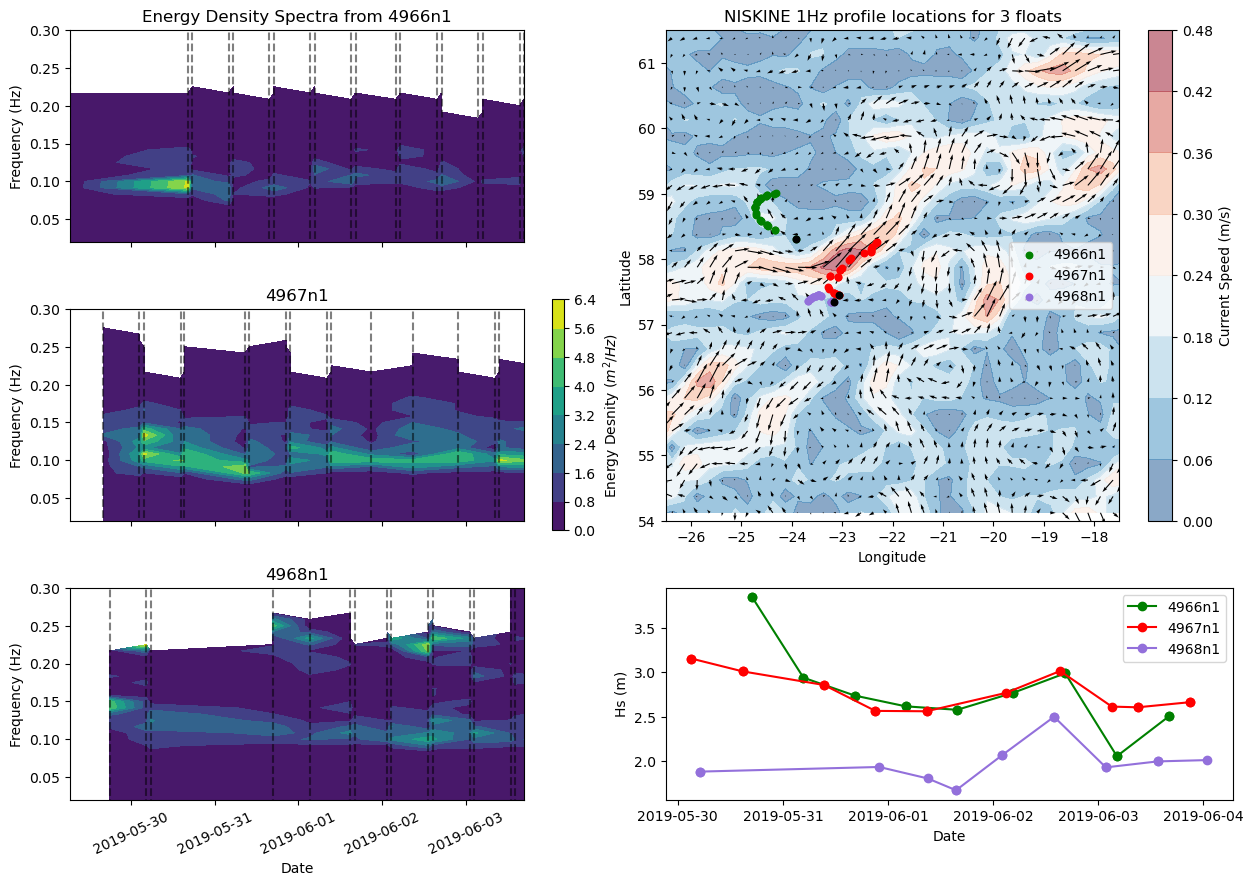

In [11]:
#from matplotlib import cm, ticker
import matplotlib.gridspec as gridspec

from matplotlib import cm, ticker
# Create 2x2 sub plots
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.05)
gs.update(hspace=0.315)

plt.figure(figsize=(15,10))




t_apex_4966n1 = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted['4966n1']])
t_apex_4967n1 = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted['4967n1']])
t_apex_4968n1 = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted['4968n1']])



#t_apex_7801n1 = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted['7801n1']])
#t_apex_7807n1 = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted['7807n1']])





#plt.subplot(121)

ax0 = plt.subplot(gs[0, 0]) # row 0, col 0

#plt.figure()
ax0.contourf(t_apex_4966n1, fwindow, spec_sorted['4966n1'].T)# locator=ticker.LogLocator(), vmin=0.01, vmax=1000)
#ax0.colorbar()
ax0.vlines(x=t_apex_4966n1, ymin=0.01, ymax=0.3, color='k', alpha=0.5, lineStyle='--')
ax0.set_xlim([t_apex_4966n1[0], t_apex_4966n1[-1]])

#ax0.scatter(t_apex_4966n1[2], 0.4, c='green', marker='v')




ax1 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[2, 0])
ax1.contourf(t_apex_4967n1, fwindow, spec_sorted['4967n1'].T)# locator=ticker.LogLocator())
#ax1.colorbar()
ax1.vlines(x=t_apex_4967n1, ymin=0.01, ymax=0.3, color='k', alpha=0.5, lineStyle='--')
#plt.colorbar()
ax1.set_xlim([t_apex_4966n1[0], t_apex_4966n1[-1]])
ax1.set_ylabel("Frequency (Hz)")
ax0.set_ylabel("Frequency (Hz)")
#ax1.set_xlabel("Date")
ax0.set_title("Energy Density Spectra from 4966n1")
ax1.set_title("4967n1")

ax0.get_xaxis().set_ticklabels([])
ax1.get_xaxis().set_ticklabels([])

#ax1.scatter(t_apex_4967n1[4], 0.4, c='red', marker="v")
#ax1.scatter(t_apex_4967n1[2], 0.4, c='red', marker="v")

ctr1 = ax3.contourf(t_apex_4968n1, fwindow, spec_sorted['4968n1'].T)#locator=ticker.LogLocator())
#ax3.scatter(t_apex_4968n1[2], 0.4, c='mediumpurple', marker="v")
cbar1 = plt.colorbar(ctr1, ax=[ax0, ax1, ax3], shrink=0.3)
cbar1.set_label(r"Energy Desnity $(m^2/Hz)$")

ax3.vlines(x=t_apex_4968n1, ymin=0.01, ymax=0.3, color='k', alpha=0.5, lineStyle='--')
#plt.colorbar()
ax3.set_xlim([t_apex_4966n1[0], t_apex_4966n1[-1]])
ax3.set_ylabel("Frequency (Hz)")
ax3.set_xlabel("Date")
ax3.set_title("4968n1")
ax3.tick_params(axis='x', labelrotation=25)

ax2 = plt.subplot(gs[:2, 1])
#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#ax2.contourf(bath_lon, bath_lat, bath_z, cmap = 'Blues_r', vmin=-3000, vmax=0)
#ax2.contour(bath_lon,bath_lat,bath_z, levels=[-1], linewidths=0.5, linestyles='solid', colors='k')
#ax2.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)
#ax2.contourf(lon[lon_inds_b:lon_inds_u]-360, lat[lat_inds_b:lat_inds_u], np.sqrt(np.square(v_temp[lat_inds_b:lat_inds_u, lon_inds_b:lon_inds_u])+np.square(u_temp[lat_inds_b:lat_inds_u, lon_inds_b:lon_inds_u])), cmap="RdBu")             
#ax2.quiver(lon[lon_inds_b:lon_inds_u]-360, lat[lat_inds_b:lat_inds_u], u_temp[lat_inds_b:lat_inds_u, lon_inds_b:lon_inds_u], v_temp[lat_inds_b:lat_inds_u, lon_inds_b:lon_inds_u])
ctr = ax2.contourf(lon_slice, lat_slice, np.sqrt(np.square(u_slice)+np.square(v_slice)), cmap = "RdBu_r", alpha=0.5)
cbar = plt.colorbar(ctr)
cbar = cbar.set_label("Current Speed (m/s)")
ax2.quiver(lon_slice, lat_slice, u_slice, v_slice)



#plt.colorbar()

#world.plot(ax=ax2)
#ax.scatter(dimes_loc_storer[:, 1], dimes_loc_storer[:, 0], color='red', s=15, label="DIMES n="+str(dimes_efr_counter))
#ax.scatter(SMILE_loc_storer[:, 1], SMILE_loc_storer[:, 0], color='green', s=15, label="SMILE n="+str(SMILE_efr_counter))
ax2.scatter(lons_sorted['4966n1'], lats_sorted['4966n1'], color='green', s=22, label='4966n1')
ax2.scatter(lons_sorted['4967n1'], lats_sorted['4967n1'], color='red', s=22, label='4967n1')
ax2.scatter(lons_sorted['4968n1'], lats_sorted['4968n1'], color='mediumpurple', s=22, label='4968n1')



ax2.scatter(lons_sorted['4966n1'][0], lats_sorted['4966n1'][0], color='k', s=22, marker='o')
ax2.scatter(lons_sorted['4967n1'][0], lats_sorted['4967n1'][0], color='k', s=22, marker='o')
#ax2.scatter(lons_sorted['4967n1'][0], lats_sorted['4967n1'][0], color='k', s=12, marker='o')
ax2.scatter(lons_sorted['4968n1'][0], lats_sorted['4968n1'][0], color='k', s=22, marker='o')


#ax.scatter(lons2, lats2, color='red', s=25)


ax2.set_xlim([-26.5, -17.5])
ax2.set_ylim([54, 61.5])
ax2.legend()


ax4 = plt.subplot(gs[2, 1])

#Average up/down profiles together
Hs_avgs_4966n1 =[]
t_avgs_4966n1 = []
for t_ind in range(1,len(t_apex_4966n1)):
    
    
    if t_apex_4966n1[t_ind]-t_apex_4966n1[t_ind-1]<datetime.timedelta(hours=3):
        Hs_avgs_4966n1 = Hs_avgs_4966n1 + [np.nanmean([Hs_sorted['4966n1'][t_ind], Hs_sorted['4966n1'][t_ind-1]])]
        t_avgs_4966n1 = t_avgs_4966n1 + [pd.to_datetime(pd.Series(t_apex_4966n1[t_ind-1:t_ind+1])).mean()]
        
    elif t_ind+1<=len(t_apex_4966n1):
        if t_apex_4966n1[t_ind]-t_apex_4966n1[t_ind+1]<datetime.timedelta(hours=3):
            Hs_avgs_4966n1 = Hs_avgs_4966n1 + [np.nanmean([Hs_sorted['4966n1'][t_ind], Hs_sorted['4966n1'][t_ind+1]])]
            t_avgs_4966n1 = t_avgs_4966n1 + [pd.to_datetime(pd.Series(t_apex_4966n1[t_ind:t_ind+2])).mean()]

    else:
        Hs_avgs_4966n1 = Hs_avgs_4966n1 + [Hs_sorted['4966n1'][t_ind]]
        t_avgs_4966n1 = t_avgs_4966n1 + [t_apex_4966n1[t_ind]]
        
Hs_avgs_4967n1 =[]
t_avgs_4967n1 = []
for t_ind in range(1,len(t_apex_4967n1)):
    if t_apex_4967n1[t_ind]-t_apex_4967n1[t_ind-1]<datetime.timedelta(hours=3):
        Hs_avgs_4967n1 = Hs_avgs_4967n1 + [np.nanmean([Hs_sorted['4967n1'][t_ind], Hs_sorted['4967n1'][t_ind-1]])]
        t_avgs_4967n1 = t_avgs_4967n1 + [pd.to_datetime(pd.Series(t_apex_4967n1[t_ind-1:t_ind+1])).mean()]
    elif t_ind+1<=len(t_apex_4967n1):
        if t_apex_4967n1[t_ind]-t_apex_4967n1[t_ind+1]<datetime.timedelta(hours=3):
            Hs_avgs_4967n1 = Hs_avgs_4967n1 + [np.nanmean([Hs_sorted['4967n1'][t_ind], Hs_sorted['4967n1'][t_ind+1]])]
            t_avgs_4967n1 = t_avgs_4967n1 + [pd.to_datetime(pd.Series(t_apex_4967n1[t_ind:t_ind+2])).mean()]
    else:
        Hs_avgs_4967n1 = Hs_avgs_4967n1 + [Hs_sorted['4967n1'][t_ind]]
        t_avgs_4967n1 = t_avgs_4967n1 + [t_apex_4967n1[t_ind]]
        
        
Hs_avgs_4968n1 =[]
t_avgs_4968n1 = []
for t_ind in range(1,len(t_apex_4968n1)):
    if t_apex_4968n1[t_ind]-t_apex_4968n1[t_ind-1]<datetime.timedelta(hours=3):
        Hs_avgs_4968n1 = Hs_avgs_4968n1 + [np.nanmean([Hs_sorted['4968n1'][t_ind], Hs_sorted['4968n1'][t_ind-1]])]
        t_avgs_4968n1 = t_avgs_4968n1 + [pd.to_datetime(pd.Series(t_apex_4968n1[t_ind-1:t_ind+1])).mean()]
        
    elif t_ind+1<len(t_apex_4968n1):
        if t_apex_4968n1[t_ind]-t_apex_4968n1[t_ind+1]<datetime.timedelta(hours=3):
            Hs_avgs_4968n1 = Hs_avgs_4968n1 + [np.nanmean([Hs_sorted['4968n1'][t_ind], Hs_sorted['4968n1'][t_ind+1]])]
            t_avgs_4968n1 = t_avgs_4968n1 + [pd.to_datetime(pd.Series(t_apex_4968n1[t_ind:t_ind+2])).mean()]
        

    else:
        Hs_avgs_4968n1 = Hs_avgs_4968n1 + [Hs_sorted['4968n1'][t_ind]]
        t_avgs_4968n1 = t_avgs_4968n1 + [t_apex_4968n1[t_ind]]
        

ax4.plot(t_avgs_4966n1, Hs_avgs_4966n1, color='green', label='4966n1', marker='o')
ax4.plot(t_avgs_4967n1, Hs_avgs_4967n1, color='red', label='4967n1', marker='o')
ax4.plot(t_avgs_4968n1, Hs_avgs_4968n1, color='mediumpurple', label='4968n1', marker='o')
ax4.set_ylabel("Hs (m)")
ax4.legend()
plt.xlabel("Date")


ax0.set_ylim([0.02, 0.3])
ax1.set_ylim([0.02, 0.3])
ax3.set_ylim([0.02, 0.3])


#ax3.annotate(text='(c)', xy=(10, 0.27), fontsize=12, ha="center")
#ax2.annotate(text='(b)', xy=(t_avgs_4966n1[0], 0.27), fontsize=12, ha="center")
#ax1.annotate(text='(a)', xy=(t_avgs_4966n1[0], 0.27), fontsize=12, ha="center")
ax2.set_ylabel("Latitude")
ax2.set_xlabel("Longitude")


ax2.set_title("NISKINE 1Hz profile locations for 3 floats")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/NISKINE/spectra_and_map.png")

In [76]:
len(t_apex_4968n1)

16

In [77]:
haversine((lats_sorted['4966n1'][6], lons_sorted['4966n1'][6]), (lats_sorted['4967n1'][4], lons_sorted['4967n1'][4]), unit=Unit.KILOMETERS)

NameError: name 'haversine' is not defined

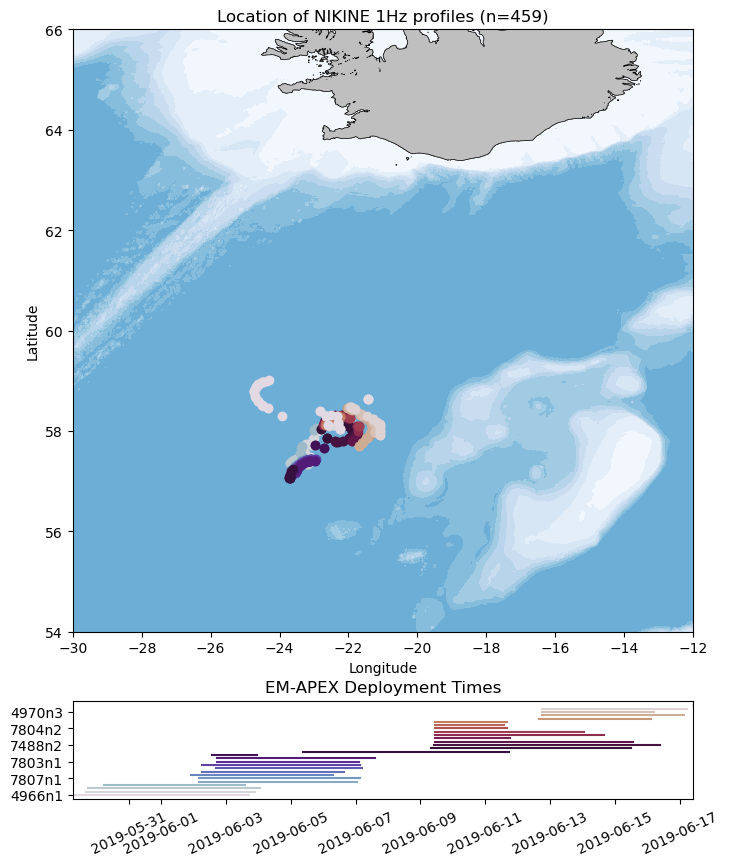

In [92]:
#make a plot with a different small row for each float, then just plot the 
import matplotlib as mpl

#fig, ax=plt.subplots(figsize=(15,15))

gs = gridspec.GridSpec(5, 1)
#gs.update(wspace=0.3)
gs.update(hspace=0.7)


plt.figure(figsize=(8,10))

t_apex_4966n1 = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted['4966n1']])
t_apex_4967n1 = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted['4967n1']])



#plt.subplot(121)
ax1 = plt.subplot(gs[:4, 0])
ax = plt.subplot(gs[4, 0]) # row 0, col 0

ax1.contourf(bath_lon, bath_lat, bath_z, cmap = 'Blues_r', vmin=-3000, vmax=0)
ax1.contour(bath_lon,bath_lat,bath_z, levels=[-1], linewidths=0.5, linestyles='solid', colors='k')
ax1.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)

#world.plot(ax=ax)

NUM_COLORS = len(NISKINE_list)

#cm = plt.get_cmap('gist_rainbow')
#ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

cmap = plt.get_cmap('twilight', NUM_COLORS)
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
counter = 0
for float_id in NISKINE_list:
    #plt.vlines(x=times_sorted[float_id], ymin=0, ymax=10)
    t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_sorted[float_id]])
    #ax.vlines(x=t_apex, ymin=0, ymax=1, color=custom_palette[counter], alpha=0.5, LineStyle='--')
    #lines.set_color(cm(i//3*3.0/NUM_COLORS))
    ax.plot(t_apex, np.ones(len(t_apex))*counter, color=custom_palette[counter])
    ax1.scatter(lons_sorted[float_id], lats_sorted[float_id], c=custom_palette[counter])
    counter+=1


    #plt.scatter(t_apex, np.ones(len(t_apex)))
    
#plt.y
#ax.set_xlim()


#ax3.xaxis.set_ticks(xtick_times) #set the ticks to be uniform
ax.set_xlim([datetime.datetime.fromtimestamp(time_sorted["4966n1"][0]), datetime.datetime.fromtimestamp(time_sorted["4971n1"][0])])
ax.set_yticks(np.arange(len(NISKINE_list))[0::5])
ax.set_yticklabels(NISKINE_list[0::5])
plt.xticks(rotation=25)
ax.set_title("EM-APEX Deployment Times")

#ax1.scatter(lons_sorted[float_id], lats_sorted[float_id], c=time_sorted[float_id])
ax1.set_xlim([-30, -12])
ax1.set_ylim([54, 66])
ax1.set_title("Location of NIKINE 1Hz profiles (n=459)")
ax1.set_ylabel("Latitude")
ax1.set_xlabel("Longitude")
#ax.set_xlim([datetime.datetime.fromtimestamp(time_sorted['4966n1'][0]), datetime.datetime.fromtimestamp(time_sorted["4970n3"][-1])])
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/NISKINE/Float_locs_times.png")

In [62]:
len(NISKINE_list)

28

In [29]:

NISKINE_list = ["4966n1",
"4967n1",
"4968n1",
"4969n1",
"4970n1",
"7807n1",
"7808n1",
"7801n1",
"7488n1",
"7802n1",
"7803n1",
"7804n1",
"7805n1",
"7806n1",
"7805n2",
"7488n2",
"4968n2",
"4970n2",
"7801n2",
"7803n2",
"7804n2",
"7807n2",
"7808n2",
"7804n3",
"7808n3",
"4970n3",
"7807n3",
"4971n1"]

fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/"

#4966n1/ohm.apl.washington.edu/~emapex/proc/dec/4966n1/"
lats1 = []
lats2 = []
lons1 = []
lons2 = []
times1=[]
times2=[]
#save all the gps data into this as we go like a buffer type thingy
GPS_storer = np.array([])
counter=0
for float_id in NISKINE_list:
    if float_id != "7808n3":
        continue
    folder_name = fname_base + float_id + "/ohm.apl.washington.edu/~emapex/proc/dec/"+float_id+"/"
    #Loop through each profile for that float
    files = os.listdir(folder_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    #print(folder_name)
    for file in efr_files:
        fname = folder_name + file
        prof_num = int(file.split('-')[2])
        
        counter+=1
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
            comp_time = mlt_efr[-1]
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = folder_name+new_file
            comp_time = mlt_efr[0]
        GPS = loadmat(gpsfname)
        
        
        if len(GPS_storer)==0:
            GPS_storer = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T
            
        else:
            temp = np.array([GPS['UXT_APF9'].T, GPS['LAT'].T, GPS['LON'].T])[:, :, 0].T
            GPS_storer = np.append(GPS_storer, temp, axis=0)
           
        #get rid of all the NaNs
        GPS_storer = GPS_storer[~np.isnan(GPS_storer[:, 1]), :]
        closest_gps_ind = np.where(np.abs(comp_time-GPS_storer[:, 0])==np.min(np.abs(comp_time-GPS_storer[:, 0])))
        closest_gps_ind = closest_gps_ind[0][0]
        lat = GPS_storer[closest_gps_ind, 1]
        lon = GPS_storer[closest_gps_ind, 2]
        gps_time = GPS_storer[closest_gps_ind, 0]
                                   
        lats1 = np.append(lats1, lat)
        lons1 = np.append(lons1, lon)
        times1 = np.append(times1, gps_time)
        
        #LAT = GPS["LAT"]
        #LON = GPS["LON"]
        
       # np.where(~np.isnan(LAT)))
        
        #TIME = GPS['UXT_GPS']
#         if len(LAT[~np.isnan(LAT)])==0:
#             continue
#         else:
#             lats1 = np.append(lats1, LAT[~np.isnan(LAT)][0])
#             #lats2 = np.append(lats2, LAT[~np.isnan(LAT)][-1])
#             #lons1 = np.append(lons1, LON[~np.isnan(LAT)][0])
#             #lons2 = np.append(lons2, LON[~np.isnan(LAT)][-1])
#             #times1 = np.append(times1, TIME[~np.isnan(LAT)][0])
#             #times2 = np.append(times2, TIME[~np.isnan(LAT)][-1])

         

            
        

In [576]:
efr_files

['ema-7808n3-0051-efr.mat',
 'ema-7808n3-0041-efr.mat',
 'ema-7808n3-0082-efr.mat',
 'ema-7808n3-0092-efr.mat',
 'ema-7808n3-0022-efr.mat',
 'ema-7808n3-0032-efr.mat',
 'ema-7808n3-0052-efr.mat',
 'ema-7808n3-0042-efr.mat',
 'ema-7808n3-0021-efr.mat',
 'ema-7808n3-0031-efr.mat',
 'ema-7808n3-0081-efr.mat',
 'ema-7808n3-0091-efr.mat',
 'ema-7808n3-0012-efr.mat',
 'ema-7808n3-0002-efr.mat',
 'ema-7808n3-0061-efr.mat',
 'ema-7808n3-0071-efr.mat',
 'ema-7808n3-0011-efr.mat',
 'ema-7808n3-0001-efr.mat',
 'ema-7808n3-0062-efr.mat',
 'ema-7808n3-0072-efr.mat']

In [332]:
len(lats1)

459

Text(0.5, 1.0, 'NISKINE 1Hz profile locations')

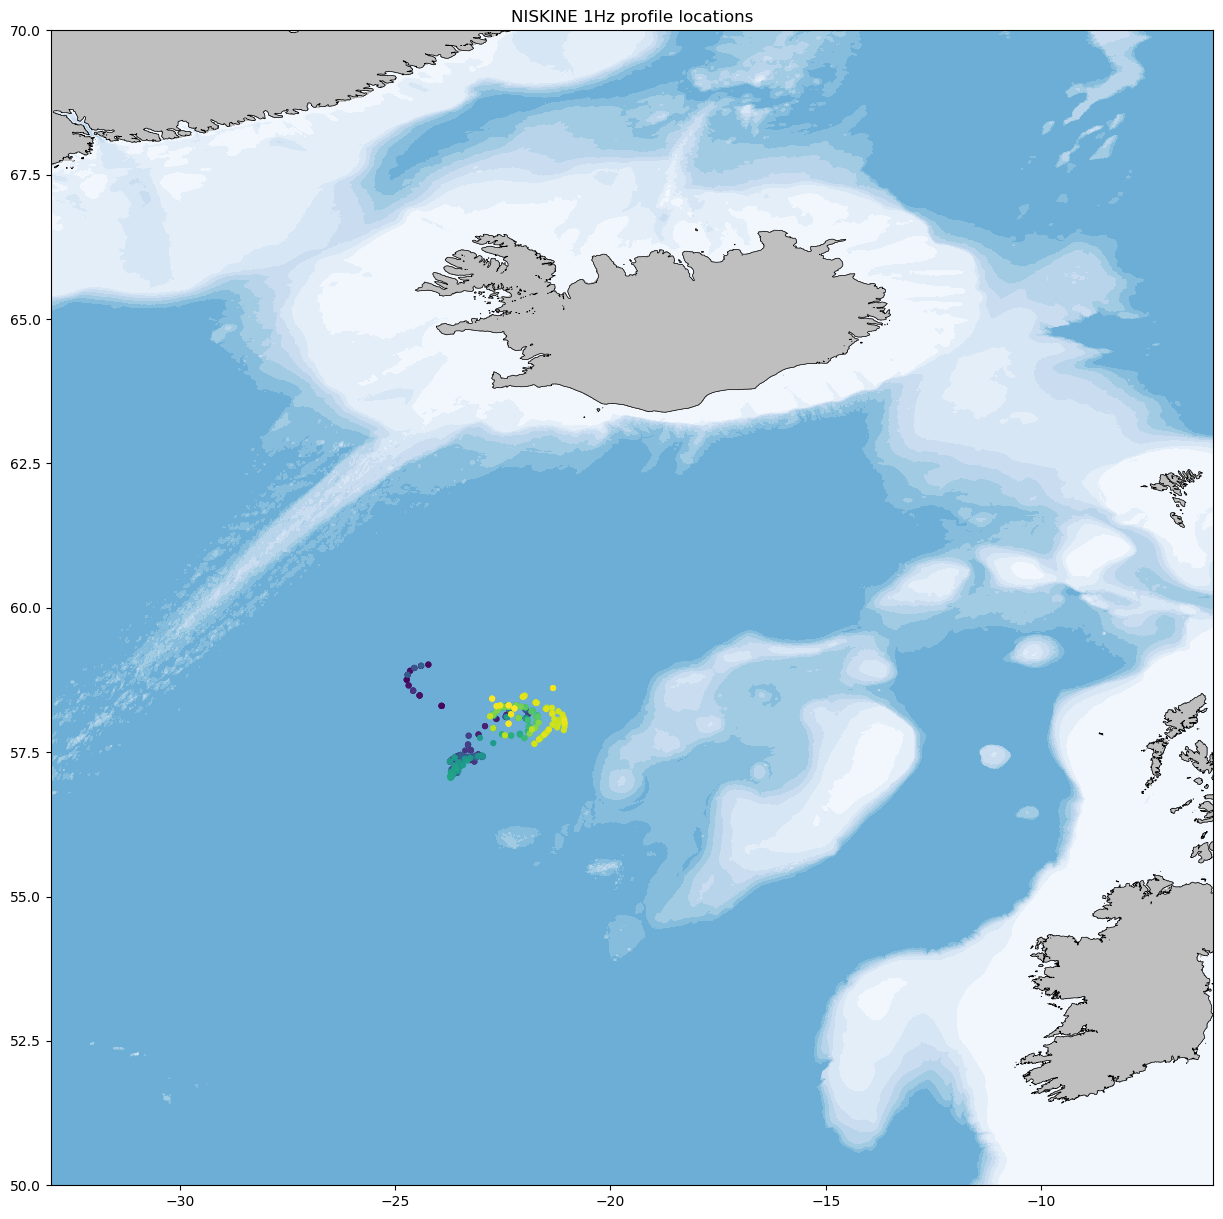

In [391]:
import geodatasets
import geopandas

#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax=plt.subplots(figsize=(15,15))
#world.plot(ax=ax)
ax.contourf(bath_lon, bath_lat, bath_z, cmap = 'Blues_r', vmin=-3000, vmax=0)
ax.contour(bath_lon,bath_lat,bath_z, levels=[-1], linewidths=0.5, linestyles='solid', colors='k')
ax.contourf(bath_lon,bath_lat,bath_z, levels=[-2, 0], cmap='binary', vmin=-2, vmax=2)
#cmap = np.linspace(np.min(times1), np.max(times1), 459)
#world.plot(ax=ax2)
#ax.scatter(dimes_loc_storer[:, 1], dimes_loc_storer[:, 0], color='red', s=15, label="DIMES n="+str(dimes_efr_counter))
#ax.scatter(SMILE_loc_storer[:, 1], SMILE_loc_storer[:, 0], color='green', s=15, label="SMILE n="+str(SMILE_efr_counter))
scat = ax.scatter(lons1, lats1, s=12, c=cmap, label="n= "+ str(len(lats1)))
#cax = divider.append_axes('right', size='5%', pad=0.05)

#ax.scatter(lons2, lats2, color='red', s=25)
#ax.scatter(dimes_loc_storer[:, 1], dimes_loc_storer[:, 0], color='red', s=15, label="DIMES n="+str(dimes_efr_counter))
#ax.scatter(SMILE_loc_storer[:, 1], SMILE_loc_storer[:, 0], color='green', s=15, label="SMILE n="+str(SMILE_efr_counter))
#ax.scatter(lons1, lats1, color='green', s=25)
#ax.scatter(lons2, lats2, color='red', s=25)


ax.set_ylim([50, 70])
ax.set_xlim([-33, -6])
#ax.colorbar()
#plt.title("SMILE and DIMES 1Hz profile locations")
plt.title("NISKINE 1Hz profile locations")

In [221]:
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/gps_files/ema-4971n1-gps.mat"
gps = loadmat(fname)
#len(gps_data['lat'])
#print(gps_data['hpid'][0][1:60])
#Want the APF-9 time
gps['mlt_apf9']

array([[737593.70706019, 737593.70706019, 737593.70707176, ...,
        738249.00943287, 738249.00943287, 738249.00944444]])

In [562]:
t_compare = time_sorted['4966n1'][6]
near_stuff = np.array([])
lats = []
lons = []
Hs = []
keys = []
for key in time_sorted.keys():
    if key == '4966n1':
        continue
    close_inds = (np.abs(time_sorted[key] - t_compare))<6*60*60
    if len(time_sorted[key][close_inds])==0:
        continue
    if len(near_stuff)==0:
        lats = np.append(lats, lats_sorted[key][close_inds])
        lons = np.append(lons, lons_sorted[key][close_inds])
        Hs = np.append(Hs, Hs_sorted[key][close_inds])
        print(key, len(Hs_sorted[key][close_inds]))
        #near_stuff = np.array([lats_sorted[key][close_inds],lons_sorted[key][close_inds],Hs_sorted[key][close_inds]])
        
    #near_stuff = np.append(near_stuff, np.array([lats_sorted[key][close_inds],lons_sorted[key][close_inds],Hs_sorted[key][close_inds]]), axis=0)


    

4967n1 2
4968n1 1


In [555]:
lats

array([57.806315  , 57.62860833, 57.39886833])

In [7]:
import netCDF4 as nc4

vel_fname = '/Users/jamesstadler/Documents/UW/TFO/Data/NISKINE/dt_global_7sat_cfo_merged_msla_h_20190530_20231116.nc'
nc_vel = nc4.Dataset(vel_fname)
lat = nc_vel.variables['latitude'][:]
lon = nc_vel.variables['longitude'][:]
u = nc_vel.variables['ugosa']
v = nc_vel.variables['vgosa']


u_temp = u[0, :, :].data
v_temp = v[0, :, :].data
ubad_inds = np.where(u_temp==u._FillValue)
vbad_inds = np.where(v_temp==v._FillValue)
#u_temp2= u_temp
u_temp[ubad_inds[0], ubad_inds[1]]=np.NaN
v_temp[vbad_inds[0], vbad_inds[1]]=np.NaN 



1371
1332


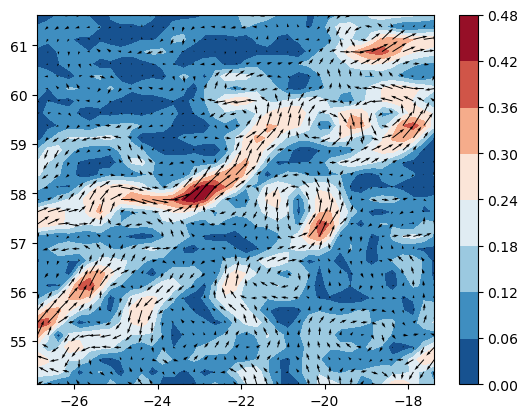

In [8]:
lat_inds_b = np.where(lat>54)[0][0]
lat_inds_u = np.where(lat<62)[0][-1]
lon_inds_b = np.where(lon-360>-27)[0][0]
lon_inds_u = np.where(lon-360<-17)[0][-1]
print(lon_inds_u)
print(lon_inds_b)

lon_slice= lon[lon_inds_b:lon_inds_u]-360
lat_slice = lat[lat_inds_b:lat_inds_u]
v_slice = v_temp[lat_inds_b:lat_inds_u, lon_inds_b:lon_inds_u]
u_slice = u_temp[lat_inds_b:lat_inds_u, lon_inds_b:lon_inds_u]


plt.contourf(lon_slice, lat_slice, np.sqrt(np.square(u_slice)+np.square(v_slice)), cmap = "RdBu_r")
plt.colorbar()
plt.quiver(lon_slice, lat_slice, u_slice, v_slice)

#plt.figure()

#plt.contourf()




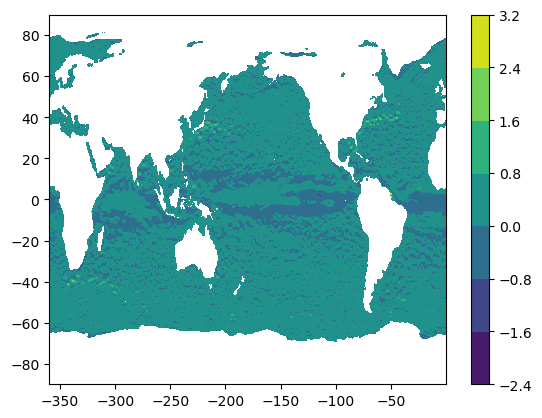

In [197]:
#fig, ax = plt.figure()
#plt.contourf(lon, lat, u[0, :, :])
plt.contourf(lon-360, lat, u[0, :, :])
plt.colorbar()
#plt.ylim([54, 62])
#plt.xlim([360-27, 360-17])
#ax.contour(bath_lon,bath_lat,bath_z, levels=[-1], linewidths=0.5, linestyles='solid', colors='k')

(-70.0, -6.0)

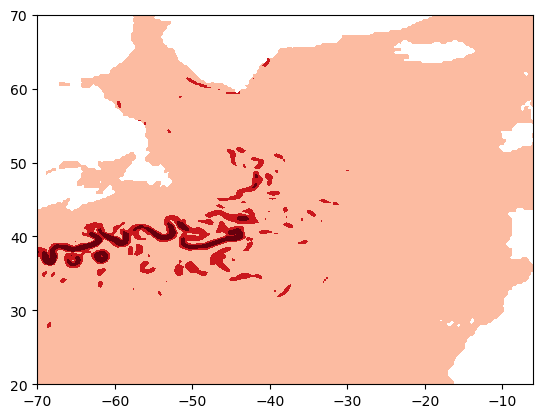

In [243]:
plt.contourf(lon-360, lat, np.sqrt(np.square(u_temp)+np.square(v_temp)), vmin=0, vmax=1, cmap='Reds')
plt.ylim([20, 70])
plt.xlim([-70, -6])

(-70.0, -6.0)

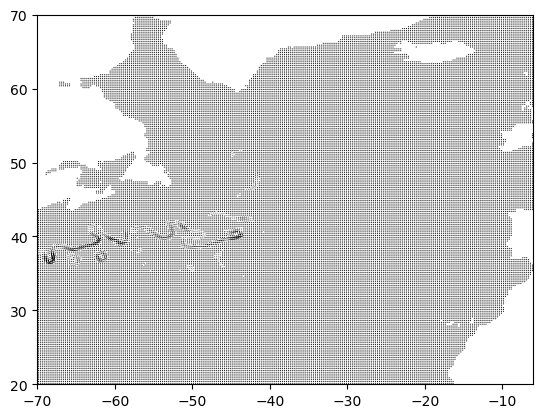

In [252]:
#plt.contourf(lon-360, lat, u_temp)
plt.quiver(lon-360, lat, u_temp, v_temp)
plt.ylim([, 70])
plt.xlim([-70, -6])
#plt.colorbar()